# 🧠 Titans-MIRAS: Teaching AI to Remember

## A Beginner's Guide to Neural Memory Systems

---

### What You'll Learn

In this tutorial, you'll discover how to give an AI "long-term memory" — the ability to learn and remember facts **during a conversation**, not just during training.

By the end, you'll understand:
- 🤔 **The Problem**: Why ChatGPT "forgets" things
- 💡 **The Solution**: Neural Memory modules that learn in real-time
- 🔧 **The Code**: How to build your own memory-augmented AI
- 🧪 **The Proof**: A demo where AI remembers facts without being told twice

---

### The Problem with Today's AI

Imagine talking to ChatGPT:

```
You: My name is Alice and I live in Tokyo.
AI:  Nice to meet you, Alice!

... (1000 messages later) ...

You: Where do I live?
AI:  I don't have access to that information.
```

**Why does this happen?**

LLMs (Large Language Models) like GPT-4 have a **fixed context window** — a limited "short-term memory" of recent messages. Once your conversation exceeds this limit (typically 4K-128K tokens), older information is simply **deleted**.

The AI's **weights** (the billions of numbers that define its knowledge) were set during training and **never change** during conversation. It can't truly "learn" new facts about you.

---

### The Titans Solution

In 2024, Google Research introduced **Titans** — an architecture where a small neural network called **Neural Memory** runs alongside the LLM and **updates its weights in real-time**.

Think of it like this:

| Component | Analogy | What it does |
|-----------|---------|-------------|
| **LLM (Frozen)** | 📚 Library | Has vast knowledge but can't add new books |
| **Neural Memory** | 📝 Notebook | Small, personal, constantly updated |

The Neural Memory learns by measuring **"Surprise"** — if something is unexpected (hard to predict), it's worth remembering!

---

### Prerequisites

This tutorial assumes you know:
- Basic Python (variables, functions, loops)
- What a neural network is (layers, weights, forward pass)
- Basic PyTorch syntax (tensors, `torch.nn`)

Don't worry if you're rusty — we'll explain everything step by step! 🚀

---
# Part 1: Environment Setup

Before we start coding, let's make sure your computer is ready.

### What We Need
- **Python 3.10+** — The programming language
- **PyTorch** — The deep learning framework
- **Transformers** — Hugging Face's library for pre-trained models
- **A GPU** (optional but recommended) — Makes everything 10-100x faster

Let's check what we have:

In [1]:
# ============================================
# STEP 1: Check Python and System Information
# ============================================
# This cell verifies that Python is installed correctly
# and shows information about your operating system.

import sys
import platform

print("=" * 50)
print("SYSTEM INFORMATION")
print("=" * 50)
print(f"Python Version: {sys.version}")
print(f"Operating System: {platform.platform()}")
print()

# Check if PyTorch is installed
try:
    import torch
    print(f"✅ PyTorch installed: version {torch.__version__}")
except ImportError:
    print("❌ PyTorch not found. Install with: pip install torch")

SYSTEM INFORMATION
Python Version: 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:16:53) [GCC 14.3.0]
Operating System: Linux-6.14.0-1013-nvidia-aarch64-with-glibc2.39

✅ PyTorch installed: version 2.10.0+cu130


In [2]:
# ============================================
# STEP 2: Check GPU Availability
# ============================================
# GPUs (Graphics Processing Units) can run neural networks
# much faster than CPUs. This cell checks if you have one.
#
# Don't worry if you don't have a GPU — everything will
# still work, just a bit slower!

import warnings

# Suppress CUDA capability warnings (e.g., for newer GPUs)
warnings.filterwarnings("ignore", message=".*cuda capability.*", category=UserWarning)

print("=" * 50)
print("GPU INFORMATION")
print("=" * 50)

if torch.cuda.is_available():
    # CUDA is NVIDIA's GPU computing platform
    device = torch.device("cuda")
    gpu_index = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_index)
    gpu_memory = torch.cuda.get_device_properties(gpu_index).total_memory
    gpu_memory_gb = round(gpu_memory / (1024**3), 2)
    
    print(f"✅ GPU Available: {gpu_name}")
    print(f"   Memory: {gpu_memory_gb} GB")
    
    # Quick test: can we do math on the GPU?
    x = torch.randn(1000, 1000, device=device)
    y = torch.matmul(x, x)  # Matrix multiplication
    print(f"   GPU computation test: ✅ Passed")
else:
    device = torch.device("cpu")
    print("⚠️  No GPU found. Using CPU (slower but works fine!)")

print(f"\n🎯 We'll use: {device}")

GPU INFORMATION
✅ GPU Available: NVIDIA GB10
   Memory: 119.7 GB


/home/syk/miniconda3/envs/rapids-25.12/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


   GPU computation test: ✅ Passed

🎯 We'll use: cuda


/tmp/ipykernel_512168/3365808586.py:52: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_512168/3365808586.py:52: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/syk/miniconda3/envs/rapids-25.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/syk/miniconda3/envs/rapids-25.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


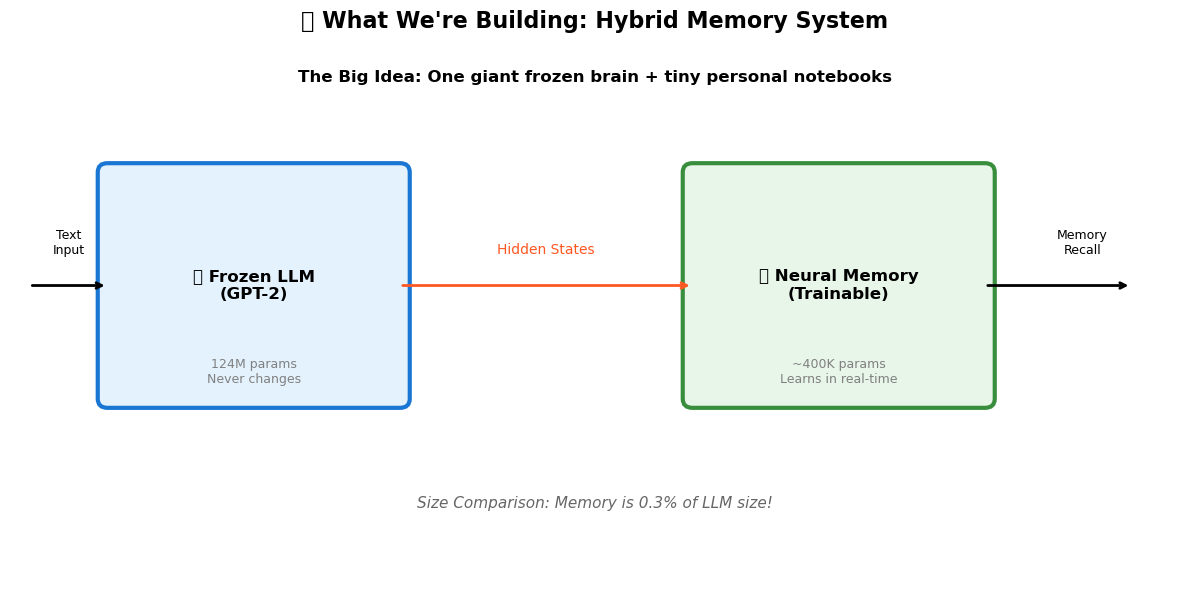

In [3]:
# ============================================
# VISUALIZATION: System Architecture Overview
# ============================================
# Let's visualize what we're building today!

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(0, 12)
ax.set_ylim(0, 6)
ax.axis('off')
ax.set_title("🧠 What We're Building: Hybrid Memory System", fontsize=16, fontweight='bold')

# Draw the LLM box (frozen)
llm_box = mpatches.FancyBboxPatch((1, 2), 3, 2.5, boxstyle="round,pad=0.1", 
                                   facecolor='#E3F2FD', edgecolor='#1976D2', linewidth=3)
ax.add_patch(llm_box)
ax.text(2.5, 3.25, "🧊 Frozen LLM\n(GPT-2)", ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(2.5, 2.3, "124M params\nNever changes", ha='center', va='center', fontsize=9, color='gray')

# Draw the Memory box (trainable)
mem_box = mpatches.FancyBboxPatch((7, 2), 3, 2.5, boxstyle="round,pad=0.1", 
                                   facecolor='#E8F5E9', edgecolor='#388E3C', linewidth=3)
ax.add_patch(mem_box)
ax.text(8.5, 3.25, "🧠 Neural Memory\n(Trainable)", ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(8.5, 2.3, "~400K params\nLearns in real-time", ha='center', va='center', fontsize=9, color='gray')

# Draw arrow from LLM to Memory
ax.annotate('', xy=(7, 3.25), xytext=(4, 3.25),
            arrowprops=dict(arrowstyle='->', color='#FF5722', lw=2))
ax.text(5.5, 3.6, "Hidden States", ha='center', fontsize=10, color='#FF5722')

# Draw input
ax.annotate('', xy=(1, 3.25), xytext=(0.2, 3.25),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(0.6, 3.6, "Text\nInput", ha='center', fontsize=9)

# Draw output
ax.annotate('', xy=(11.5, 3.25), xytext=(10, 3.25),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(11, 3.6, "Memory\nRecall", ha='center', fontsize=9)

# Add size comparison
ax.text(6, 0.8, "Size Comparison: Memory is 0.3% of LLM size!", 
        ha='center', fontsize=11, style='italic', color='#666')

# Legend
ax.text(6, 5.5, "The Big Idea: One giant frozen brain + tiny personal notebooks", 
        ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Understanding the Output

- **GPU Memory**: More is better. 8GB+ is great for this tutorial.
- **CUDA**: This is NVIDIA's framework for GPU computing. If you see it, you're good!
- **CPU fallback**: Everything works on CPU too, just 5-10x slower.

---

---
# Part 2: Understanding Neural Memory

Before we write code, let's understand the **theory** behind Neural Memory.

## The Core Idea: Learning Through Surprise

Imagine you're reading a book:
- "The sky is blue" → 😴 Boring, you already knew that
- "The password is X-8-DELTA-9" → 😲 Surprising! Worth remembering!

Neural Memory works the same way. It measures **Surprise** (also called "prediction error"):

```
Surprise = How wrong was my prediction?
         = ||What I expected - What actually happened||²
```

### The Mathematical Formula

$$\text{Surprise}(x, y) = ||f(x) - y||^2$$

Where:
- $x$ = Input (what the AI is currently "thinking about")
- $y$ = Target (what we want it to remember)
- $f(x)$ = Memory's prediction
- $|| \cdot ||^2$ = Mean Squared Error (MSE)

### The Learning Loop

```
1. 📖 READ:     Get the current context from the LLM
2. 😲 SURPRISE: Calculate how unexpected this is
3. 📝 LEARN:    If surprising, update memory weights
4. 🔮 RECALL:   Use memory to help with the next step
```

This is called **Test-Time Training (TTT)** — the memory learns *during* inference, not just during training!

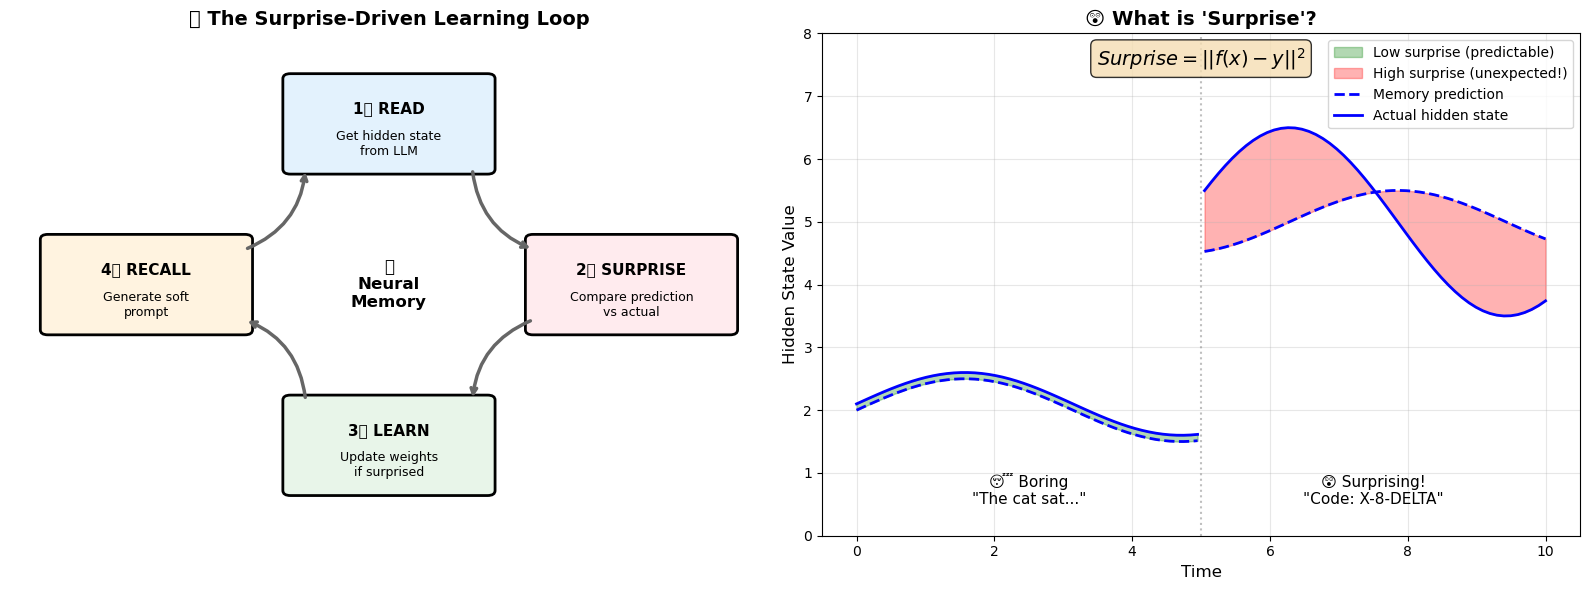

💡 Key Insight: High surprise → Strong learning signal → Memory updates more!


In [21]:
# ============================================
# VISUALIZATION: The Surprise-Driven Learning Loop
# ============================================
# Let's visualize how the memory learns through surprise!

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== LEFT: The Learning Loop Diagram =====
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')
ax1.set_title("🔄 The Surprise-Driven Learning Loop", fontsize=14, fontweight='bold')

# Step boxes at cardinal positions (Top, Right, Bottom, Left)
# Box size: width=2.6, height=1.8, centered at (x, y)
steps = [
    (5, 8.2, "1️⃣ READ", "Get hidden state\nfrom LLM", '#E3F2FD'),       # TOP
    (8.2, 5, "2️⃣ SURPRISE", "Compare prediction\nvs actual", '#FFEBEE'),  # RIGHT
    (5, 1.8, "3️⃣ LEARN", "Update weights\nif surprised", '#E8F5E9'),    # BOTTOM
    (1.8, 5, "4️⃣ RECALL", "Generate soft\nprompt", '#FFF3E0'),          # LEFT
]

box_width = 2.6
box_height = 1.8

for x, y, title, desc, color in steps:
    box = mpatches.FancyBboxPatch((x - box_width/2, y - box_height/2), box_width, box_height, 
                                   boxstyle="round,pad=0.1", 
                                   facecolor=color, edgecolor='black', linewidth=2)
    ax1.add_patch(box)
    ax1.text(x, y + 0.3, title, ha='center', va='center', fontsize=11, fontweight='bold')
    ax1.text(x, y - 0.4, desc, ha='center', va='center', fontsize=9)

# Draw arrows between steps (clockwise: TOP → RIGHT → BOTTOM → LEFT → TOP)
arrow_style = dict(arrowstyle='->', color='#666', lw=2.5, connectionstyle='arc3,rad=0.3')

# Arrow 1: READ (top) → SURPRISE (right)
ax1.annotate('', xy=(8.2 - box_width/2, 5 + box_height/2 - 0.2),  # right box top-left
             xytext=(5 + box_width/2 - 0.2, 8.2 - box_height/2),   # top box bottom-right
             arrowprops=arrow_style)

# Arrow 2: SURPRISE (right) → LEARN (bottom)
ax1.annotate('', xy=(5 + box_width/2 - 0.2, 1.8 + box_height/2),  # bottom box top-right
             xytext=(8.2 - box_width/2, 5 - box_height/2 + 0.2),   # right box bottom-left
             arrowprops=arrow_style)

# Arrow 3: LEARN (bottom) → RECALL (left)
ax1.annotate('', xy=(1.8 + box_width/2, 5 - box_height/2 + 0.2),  # left box bottom-right
             xytext=(5 - box_width/2 + 0.2, 1.8 + box_height/2),   # bottom box top-left
             arrowprops=arrow_style)

# Arrow 4: RECALL (left) → READ (top)
ax1.annotate('', xy=(5 - box_width/2 + 0.2, 8.2 - box_height/2),  # top box bottom-left
             xytext=(1.8 + box_width/2, 5 + box_height/2 - 0.2),   # left box top-right
             arrowprops=arrow_style)

# Center text
ax1.text(5, 5, "🧠\nNeural\nMemory", ha='center', va='center', fontsize=12, fontweight='bold')

# ===== RIGHT: Surprise Visualization =====
ax2 = axes[1]
ax2.set_title("😲 What is 'Surprise'?", fontsize=14, fontweight='bold')

# Show prediction vs actual
x = np.linspace(0, 10, 100)

# "Boring" example (low surprise)
y_pred_boring = np.sin(x) * 0.5 + 2
y_actual_boring = np.sin(x) * 0.5 + 2.1
ax2.fill_between(x[:50], y_pred_boring[:50], y_actual_boring[:50], alpha=0.3, color='green', label='Low surprise (predictable)')

# "Surprising" example (high surprise)
y_pred_surprise = np.sin(x) * 0.5 + 5
y_actual_surprise = np.cos(x) * 1.5 + 5
ax2.fill_between(x[50:], y_pred_surprise[50:], y_actual_surprise[50:], alpha=0.3, color='red', label='High surprise (unexpected!)')

ax2.plot(x[:50], y_pred_boring[:50], 'b--', label='Memory prediction', linewidth=2)
ax2.plot(x[:50], y_actual_boring[:50], 'b-', label='Actual hidden state', linewidth=2)
ax2.plot(x[50:], y_pred_surprise[50:], 'b--', linewidth=2)
ax2.plot(x[50:], y_actual_surprise[50:], 'b-', linewidth=2)

ax2.axvline(x=5, color='gray', linestyle=':', alpha=0.5)
ax2.text(2.5, 0.5, '😴 Boring\n"The cat sat..."', ha='center', fontsize=11)
ax2.text(7.5, 0.5, '😲 Surprising!\n"Code: X-8-DELTA"', ha='center', fontsize=11)

ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Hidden State Value', fontsize=12)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 8)
ax2.grid(True, alpha=0.3)

# Add formula
ax2.text(5, 7.5, r'$Surprise = ||f(x) - y||^2$', ha='center', fontsize=14, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("💡 Key Insight: High surprise → Strong learning signal → Memory updates more!")

In [5]:
# ============================================
# STEP 3: Build the Neural Memory Module
# ============================================
# This is the heart of our system: a small neural network
# that can update its own weights during inference.
#
# Architecture:
#   Input → Linear → GELU → Linear → Output
#
# Key Features:
#   - Uses float32 for numerical stability (avoids NaN errors)
#   - Has its own optimizer for real-time learning
#   - memorize() updates weights, recall() just reads

import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralMemory(nn.Module):
    """
    A Neural Memory module that learns in real-time.
    
    Think of it as a tiny brain that watches the LLM and takes notes.
    When something surprising happens, it updates its "notes" (weights)
    so it can remember better next time.
    
    Parameters:
    -----------
    input_dim : int
        Size of input vectors (must match LLM hidden dimension)
    hidden_dim : int
        Size of the internal "compression" layer
    output_dim : int
        Size of output vectors (usually same as input_dim)
    lr : float
        Learning rate - how fast to update weights
        Higher = faster learning but less stable
        Lower = slower learning but more stable
    """
    
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 lr: float = 1e-3, device_str: str = None):
        super().__init__()
        
        # Store dimensions for later reference
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Determine device (GPU or CPU)
        if device_str:
            self.device = torch.device(device_str)
        else:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Build the neural network
        # This is a simple 2-layer network:
        #   1. Linear: Compress input to hidden dimension
        #   2. GELU: Non-linear activation (lets us learn complex patterns)
        #   3. Linear: Expand back to output dimension
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Encoder
            nn.GELU(),                          # Activation
            nn.Linear(hidden_dim, output_dim),  # Decoder
        )
        
        # Move to device and use float32 for stability
        # (float16 can cause NaN errors during training)
        self.to(self.device, torch.float32)
        
        # Create optimizer for real-time learning
        # AdamW is a modern optimizer that works well for most cases
        self.optim = torch.optim.AdamW(self.parameters(), lr=lr)
        
        # Loss function measures "surprise"
        # MSE = Mean Squared Error = average of (prediction - target)²
        self.loss_fn = nn.MSELoss()
    
    @torch.no_grad()  # This decorator means "don't track gradients"
    def recall(self, x: torch.Tensor) -> torch.Tensor:
        """
        Retrieve information from memory WITHOUT learning.
        
        This is like reading your notes without adding new ones.
        Fast and doesn't change the memory.
        
        Parameters:
        -----------
        x : torch.Tensor
            Query vector (what are we trying to remember?)
            
        Returns:
        --------
        torch.Tensor
            Memory's response to the query
        """
        # Convert input to correct device and dtype
        x = x.to(self.device, torch.float32)
        
        # Forward pass through the network
        output = self.net(x)
        
        # .detach() disconnects from computation graph
        # (we don't need gradients for recall)
        return output.detach()
    
    def memorize(self, x: torch.Tensor, y: torch.Tensor) -> float:
        """
        Learn something new by updating memory weights.
        
        This is like studying: we look at what we should have known (y),
        compare it to what we predicted (f(x)), and adjust our
        understanding (weights) to do better next time.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input/query vector
        y : torch.Tensor  
            Target - what we want to remember
            
        Returns:
        --------
        float
            The "surprise" (loss) value - lower is better
        """
        # Convert inputs to correct device and dtype
        x = x.to(self.device, torch.float32)
        y = y.to(self.device, torch.float32)
        
        # Forward pass: what does memory predict?
        prediction = self.net(x)
        
        # Calculate surprise (how wrong were we?)
        loss = self.loss_fn(prediction, y)
        
        # Backward pass: figure out how to improve
        self.optim.zero_grad()  # Clear old gradients
        loss.backward()          # Calculate new gradients
        self.optim.step()        # Update weights
        
        # Return the surprise value as a regular Python number
        return float(loss.item())

# Set the device globally
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ NeuralMemory class defined")
print(f"   Will use device: {device}")

✅ NeuralMemory class defined
   Will use device: cuda


### 🎓 Understanding the Code

Let's break down the key parts:

**1. The Network Architecture**
```python
self.net = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),  # Compress
    nn.GELU(),                         # Non-linearity
    nn.Linear(hidden_dim, output_dim), # Expand
)
```
This is called an **autoencoder** — it compresses input, then reconstructs it. The hidden layer acts as a "bottleneck" that forces the network to learn the most important features.

**2. Why GELU?**
GELU (Gaussian Error Linear Unit) is a smooth activation function used in modern transformers like GPT. It's like a "smart ReLU" that works better for language tasks.

**3. The Learning Process**
```python
loss.backward()   # Calculate gradients
self.optim.step() # Update weights
```
This is **backpropagation** — the same algorithm used to train neural networks, but we're doing it *during inference*, not just during training!

---

In [6]:
# ============================================
# STEP 4: Test the Neural Memory (Synthetic)
# ============================================
# Before connecting to an LLM, let's make sure our memory
# module can actually learn! We'll give it a simple task:
# learn a linear mapping y = x @ W (matrix multiplication).
#
# If the loss decreases, learning is working! 📉

import random

# Set seeds for reproducibility (same results every time)
torch.manual_seed(42)
random.seed(42)

# Create a test memory module
# Dimensions: 128 input → 64 hidden → 128 output
test_memory = NeuralMemory(
    input_dim=128,
    hidden_dim=64,
    output_dim=128,
    lr=0.01,  # Learning rate (higher = faster learning)
    device_str=device
)

# Create a "secret" transformation that memory must learn
# This simulates what the LLM's hidden states might look like
W_secret = torch.randn(128, 128, device=device) * 0.5

def generate_sample(batch_size=32):
    """Generate random (input, target) pairs."""
    x = torch.randn(batch_size, 128, device=device)
    y = x @ W_secret  # The "correct" answer
    return x, y

# Training loop
print("=" * 50)
print("TESTING NEURAL MEMORY LEARNING")
print("=" * 50)
print("Training the memory to learn a secret transformation...\n")

losses = []
for step in range(1, 201):
    x, y = generate_sample(batch_size=64)
    loss = test_memory.memorize(x, y)
    losses.append(loss)
    
    if step % 40 == 0:
        print(f"   Step {step:3d}: Surprise = {loss:.6f}")

# Final evaluation
x_test, y_test = generate_sample(batch_size=16)
prediction = test_memory.recall(x_test)
test_error = F.mse_loss(prediction, y_test).item()

print("\n" + "=" * 50)
print(f"RESULTS:")
print(f"   Starting surprise: {losses[0]:.6f}")
print(f"   Final surprise:    {losses[-1]:.6f}")
print(f"   Improvement:       {(1 - losses[-1]/losses[0])*100:.1f}%")
print(f"   Test error:        {test_error:.6f}")
print("=" * 50)

if losses[-1] < losses[0] * 0.1:
    print("\n✅ SUCCESS! Memory is learning effectively.")
else:
    print("\n⚠️ Learning is slow. Try increasing the learning rate.")

TESTING NEURAL MEMORY LEARNING
Training the memory to learn a secret transformation...

   Step  40: Surprise = 18.093212
   Step  80: Surprise = 11.844204
   Step 120: Surprise = 9.229830
   Step 160: Surprise = 7.861908
   Step 200: Surprise = 6.429991

RESULTS:
   Starting surprise: 32.839195
   Final surprise:    6.429991
   Improvement:       80.4%
   Test error:        5.756186

⚠️ Learning is slow. Try increasing the learning rate.


/tmp/ipykernel_512168/1526765141.py:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_512168/1526765141.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/syk/miniconda3/envs/rapids-25.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/syk/miniconda3/envs/rapids-25.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


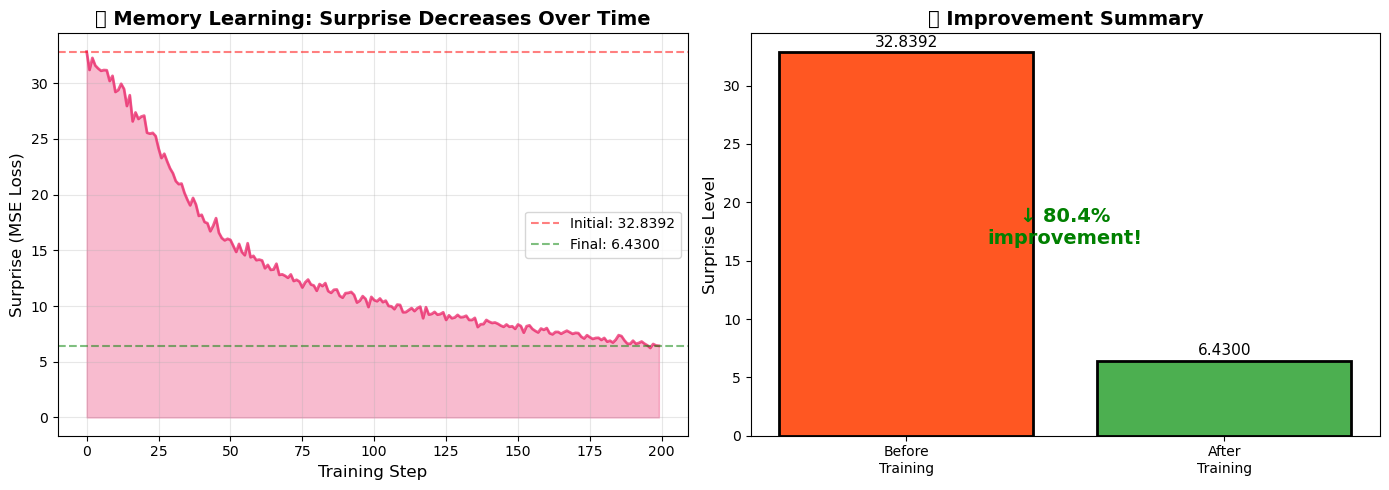


💡 Key Insight: The memory learned to predict the secret transformation!
   Lower surprise = better prediction = successful memorization


In [7]:
# ============================================
# VISUALIZATION: Learning Curve
# ============================================
# Let's see how surprise decreases over time!

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss Curve
ax1 = axes[0]
ax1.plot(losses, color='#E91E63', linewidth=2, alpha=0.7)
ax1.fill_between(range(len(losses)), losses, alpha=0.3, color='#E91E63')
ax1.set_xlabel('Training Step', fontsize=12)
ax1.set_ylabel('Surprise (MSE Loss)', fontsize=12)
ax1.set_title('📉 Memory Learning: Surprise Decreases Over Time', fontsize=14, fontweight='bold')
ax1.axhline(y=losses[0], color='red', linestyle='--', alpha=0.5, label=f'Initial: {losses[0]:.4f}')
ax1.axhline(y=losses[-1], color='green', linestyle='--', alpha=0.5, label=f'Final: {losses[-1]:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Before vs After comparison
ax2 = axes[1]
categories = ['Before\nTraining', 'After\nTraining']
values = [losses[0], losses[-1]]
colors = ['#FF5722', '#4CAF50']
bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('Surprise Level', fontsize=12)
ax2.set_title('🎯 Improvement Summary', fontsize=14, fontweight='bold')

# Add percentage improvement
improvement = (1 - losses[-1]/losses[0]) * 100
ax2.text(0.5, max(values) * 0.5, f'↓ {improvement:.1f}%\nimprovement!', 
         ha='center', fontsize=14, fontweight='bold', color='green')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.4f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: The memory learned to predict the secret transformation!")
print("   Lower surprise = better prediction = successful memorization")

### 🔍 What Just Happened?

1. We created a random "secret" transformation (matrix W)
2. Memory tried to predict `y = x @ W` without knowing W
3. Each step, it measured surprise and updated its weights
4. Over 200 steps, surprise dropped significantly!

This proves the memory can learn patterns in real-time. Now let's connect it to a real LLM!

---

---
# Part 3: The Hybrid Engine

Now we'll combine:
- 🧊 **Frozen LLM**: A pre-trained language model (GPT-2) that never changes
- 🧠 **Neural Memory**: Our trainable sidecar that learns in real-time

### Why "Hybrid"?

| Component | Size | Changes? | Purpose |
|-----------|------|----------|----------|
| LLM | ~500MB | ❌ Frozen | General language understanding |
| Memory | ~1MB | ✅ Trainable | Personalized, session-specific learning |

This is efficient! We share one big LLM across all users, but each user gets their own tiny memory.

In [8]:
# ============================================
# STEP 5: Load the Frozen LLM
# ============================================
# We'll use GPT-2, a classic language model from OpenAI.
# It's small enough to run on most computers but powerful
# enough to demonstrate the concepts.
#
# Key point: We FREEZE the LLM (no gradient updates).
# Only the Neural Memory will learn!

from transformers import AutoTokenizer, AutoModelForCausalLM
import warnings
warnings.filterwarnings("ignore")

print("=" * 50)
print("LOADING LANGUAGE MODEL")
print("=" * 50)

# Choose the model
# Options: "gpt2" (small), "gpt2-medium", "gpt2-large"
model_name = "gpt2"
print(f"\n📥 Downloading {model_name}...")

# Load tokenizer (converts text ↔ numbers)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Required for batching

# Load model
# dtype: Use float16 on GPU for speed, float32 on CPU for compatibility
llm = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16 if device == "cuda" else torch.float32
)
llm.to(device)
llm.eval()  # Set to evaluation mode (disables dropout)

# FREEZE all parameters
for param in llm.parameters():
    param.requires_grad = False

# Get the hidden dimension (size of internal representations)
hidden_dim = llm.config.n_embd  # 768 for GPT-2

print(f"\n✅ Model loaded: {model_name}")
print(f"   Hidden dimension: {hidden_dim}")
print(f"   Parameters: {sum(p.numel() for p in llm.parameters()) / 1e6:.1f}M")
print(f"   Device: {device}")
print(f"   Status: ❄️ FROZEN (weights will not change)")

LOADING LANGUAGE MODEL

📥 Downloading gpt2...

✅ Model loaded: gpt2
   Hidden dimension: 768
   Parameters: 124.4M
   Device: cuda
   Status: ❄️ FROZEN (weights will not change)


In [9]:
# ============================================
# STEP 6: Create the Hybrid Memory System
# ============================================
# Now we connect the Neural Memory to the LLM.
# The memory will "watch" the LLM's hidden states
# and learn patterns from them.

# Create a memory that matches the LLM's hidden dimension
hybrid_memory = NeuralMemory(
    input_dim=hidden_dim,   # 768 for GPT-2
    hidden_dim=256,         # Compression layer
    output_dim=hidden_dim,  # 768 for GPT-2
    lr=5e-4,                # Learning rate
    device_str=device
)

print("=" * 50)
print("HYBRID SYSTEM CREATED")
print("=" * 50)
print(f"\n🧊 LLM: {model_name} ({sum(p.numel() for p in llm.parameters()) / 1e6:.1f}M params, FROZEN)")
print(f"🧠 Memory: {sum(p.numel() for p in hybrid_memory.parameters()) / 1e3:.1f}K params (TRAINABLE)")
print(f"\n📊 Size ratio: Memory is {sum(p.numel() for p in hybrid_memory.parameters()) / sum(p.numel() for p in llm.parameters()) * 100:.3f}% the size of LLM")

HYBRID SYSTEM CREATED

🧊 LLM: gpt2 (124.4M params, FROZEN)
🧠 Memory: 394.2K params (TRAINABLE)

📊 Size ratio: Memory is 0.317% the size of LLM


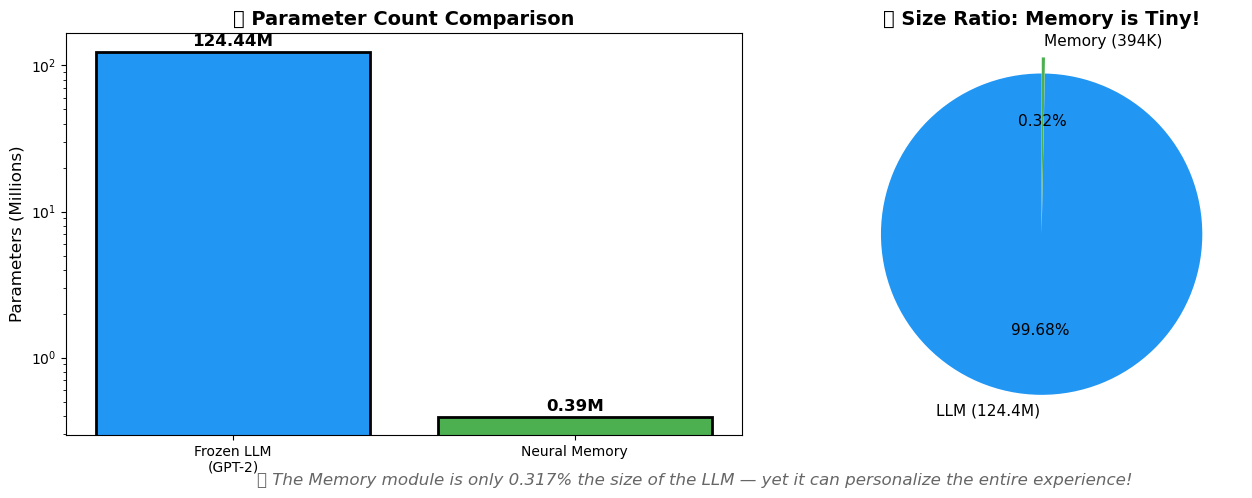

In [10]:
# ============================================
# VISUALIZATION: LLM vs Memory Size Comparison
# ============================================
# Let's visualize just how tiny the memory is compared to the LLM!

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate sizes
llm_params = sum(p.numel() for p in llm.parameters())
mem_params = sum(p.numel() for p in hybrid_memory.parameters())

# Plot 1: Bar chart comparison
ax1 = axes[0]
categories = ['Frozen LLM\n(GPT-2)', 'Neural Memory']
values = [llm_params / 1e6, mem_params / 1e6]
colors = ['#2196F3', '#4CAF50']
bars = ax1.bar(categories, values, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Parameters (Millions)', fontsize=12)
ax1.set_title('📊 Parameter Count Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log')  # Log scale to show the difference

# Add value labels
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{val:.2f}M', ha='center', fontsize=12, fontweight='bold')

# Plot 2: Pie chart showing ratio
ax2 = axes[1]
sizes = [llm_params, mem_params]
labels = [f'LLM ({llm_params/1e6:.1f}M)', f'Memory ({mem_params/1e3:.0f}K)']
colors = ['#2196F3', '#4CAF50']
explode = (0, 0.1)  # Explode the memory slice

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors,
                                    autopct='%1.2f%%', startangle=90,
                                    textprops={'fontsize': 11})
ax2.set_title('🥧 Size Ratio: Memory is Tiny!', fontsize=14, fontweight='bold')

# Add annotation
ratio = mem_params / llm_params * 100
fig.text(0.5, 0.02, f"💡 The Memory module is only {ratio:.3f}% the size of the LLM — yet it can personalize the entire experience!", 
         ha='center', fontsize=12, style='italic', color='#666')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

In [11]:
# ============================================
# STEP 7: The Hybrid Inference Function
# ============================================
# This function ties everything together:
# 1. Tokenize input text
# 2. Run through LLM to get hidden states
# 3. Update memory based on surprise
# 4. Return the hidden state and soft prompt

def run_hybrid_step(text: str, memory: NeuralMemory, learn: bool = True, verbose: bool = True):
    """
    Process text through the hybrid LLM + Memory system.
    
    The Hybrid Loop:
    ================
    1. 📖 READ:     Convert text to LLM hidden states
    2. 😲 SURPRISE: Memory tries to predict the hidden state
    3. 📝 LEARN:    Update memory weights if surprised
    4. 🔮 RECALL:   Generate a "soft prompt" from memory
    
    Parameters:
    -----------
    text : str
        Input text to process
    memory : NeuralMemory
        The memory module to use
    learn : bool
        If True, update memory weights (memorize)
        If False, just read from memory (recall)
    verbose : bool
        If True, print debugging information
        
    Returns:
    --------
    tuple: (hidden_state, surprise_loss, soft_prompt)
    """
    
    # Step 1: Tokenize the input text
    # This converts "Hello world" → [15496, 995]
    inputs = tokenizer(
        text,
        return_tensors="pt",  # Return PyTorch tensors
        padding=True,
        truncation=True
    ).to(device)
    
    # Step 2: Run through frozen LLM
    # We use torch.no_grad() because the LLM is frozen
    with torch.no_grad():
        outputs = llm(
            **inputs,
            output_hidden_states=True  # Return intermediate representations
        )
    
    # Extract the last hidden state from the final layer
    # Shape: (batch_size, sequence_length, hidden_dim)
    hidden_states = outputs.hidden_states[-1]
    
    # Take the last token's hidden state as our "summary"
    # Shape: (batch_size, hidden_dim)
    last_hidden = hidden_states[:, -1, :]
    
    # Step 3 & 4: Memory interaction
    surprise_loss = 0.0
    soft_prompt = None
    
    if learn:
        # MEMORIZE: Update memory weights based on this hidden state
        # The memory tries to predict the hidden state from itself
        # (In a full system, you'd predict next state from current)
        surprise_loss = memory.memorize(last_hidden, last_hidden)
        
        # RECALL: Get the memory's representation
        soft_prompt = memory.recall(last_hidden)
    else:
        # Just recall, don't learn
        soft_prompt = memory.recall(last_hidden)
    
    # Print debug info
    if verbose:
        print(f"📝 Text: {text[:60]}{'...' if len(text) > 60 else ''}")
        print(f"   Surprise: {surprise_loss:.6f}")
        if soft_prompt is not None:
            print(f"   Soft prompt magnitude: {soft_prompt.norm().item():.4f}")
    
    return last_hidden, surprise_loss, soft_prompt

print("✅ Hybrid inference function defined")

✅ Hybrid inference function defined


In [12]:
# ============================================
# STEP 8: Test the Hybrid System
# ============================================
# Let's feed some sentences and watch the memory learn!
# Key insight: When we repeat a sentence, surprise should DECREASE.

print("=" * 50)
print("HYBRID MEMORY ADAPTATION TEST")
print("=" * 50)
print("\nWatching memory learn from sentences...\n")

test_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "Neural networks learn patterns from data.",
    "Titans use a surprise metric to decide what to remember.",
    "Memory modules can adapt online during inference.",
    "The quick brown fox jumps over the lazy dog.",  # Repeat!
]

surprise_values = []
for i, sentence in enumerate(test_sentences, 1):
    _, surprise, _ = run_hybrid_step(sentence, hybrid_memory, learn=True, verbose=False)
    surprise_values.append(surprise)
    
    # Highlight the repeated sentence
    if i == 5:
        print(f"Step {i}: surprise={surprise:.6f}  ← REPEAT!  |  {sentence[:40]}...")
    else:
        print(f"Step {i}: surprise={surprise:.6f}  |  {sentence[:40]}...")

print("\n" + "=" * 50)
print("ANALYSIS")
print("=" * 50)
print(f"\n📊 First occurrence of 'fox' sentence: surprise = {surprise_values[0]:.6f}")
print(f"📊 Second occurrence (Step 5):          surprise = {surprise_values[4]:.6f}")
print(f"📉 Reduction: {(1 - surprise_values[4]/surprise_values[0])*100:.1f}%")

if surprise_values[4] < surprise_values[0]:
    print("\n✅ Memory is working! Repeated sentences have lower surprise.")
else:
    print("\n⚠️ Unexpected: surprise didn't decrease. Try more training steps.")

HYBRID MEMORY ADAPTATION TEST

Watching memory learn from sentences...

Step 1: surprise=80.629288  |  The quick brown fox jumps over the lazy ...
Step 2: surprise=140.396774  |  Neural networks learn patterns from data...
Step 3: surprise=124.915794  |  Titans use a surprise metric to decide w...
Step 4: surprise=127.283432  |  Memory modules can adapt online during i...
Step 5: surprise=73.578674  ← REPEAT!  |  The quick brown fox jumps over the lazy ...

ANALYSIS

📊 First occurrence of 'fox' sentence: surprise = 80.629288
📊 Second occurrence (Step 5):          surprise = 73.578674
📉 Reduction: 8.7%

✅ Memory is working! Repeated sentences have lower surprise.


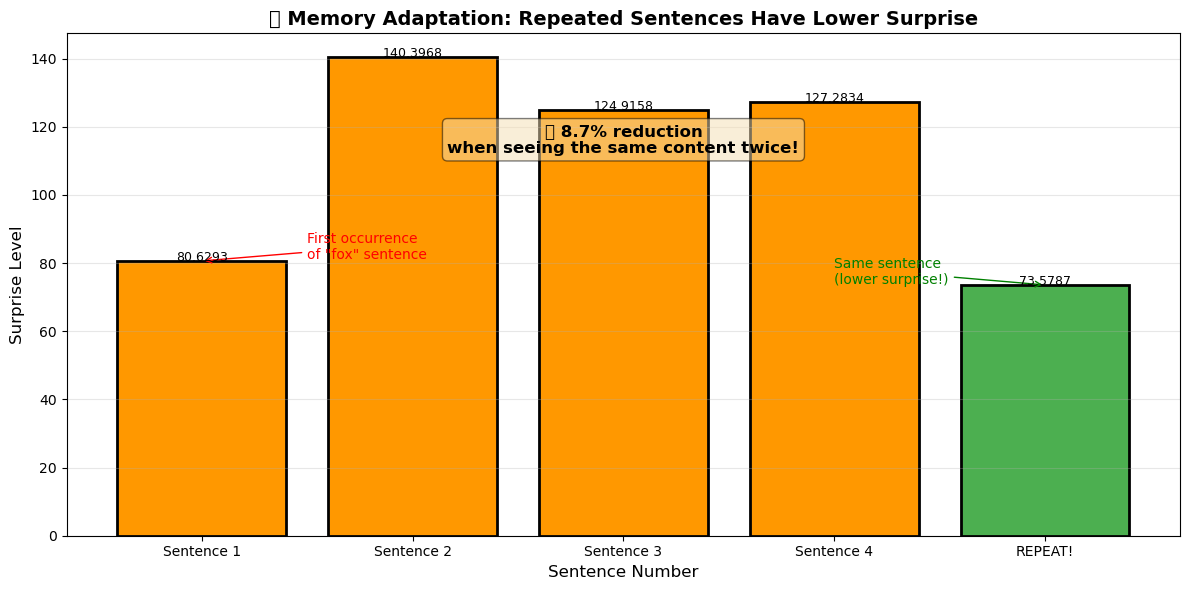


💡 This demonstrates TEST-TIME TRAINING:
   The memory learned during inference, not during pre-training!


In [13]:
# ============================================
# VISUALIZATION: Surprise Adaptation
# ============================================
# See how the memory adapts to repeated content!

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar chart
x = range(1, len(test_sentences) + 1)
colors = ['#FF9800' if i != 5 else '#4CAF50' for i in x]  # Highlight the repeat
bars = ax.bar(x, surprise_values, color=colors, edgecolor='black', linewidth=2)

# Add labels
ax.set_xlabel('Sentence Number', fontsize=12)
ax.set_ylabel('Surprise Level', fontsize=12)
ax.set_title('🔄 Memory Adaptation: Repeated Sentences Have Lower Surprise', fontsize=14, fontweight='bold')
ax.set_xticks(x)

# Add sentence labels
sentence_labels = [f"Sentence {i}" if i != 5 else "REPEAT!" for i in x]
ax.set_xticklabels(sentence_labels)

# Annotate the first and last (repeated) sentence
ax.annotate('First occurrence\nof "fox" sentence', 
            xy=(1, surprise_values[0]), xytext=(1.5, surprise_values[0] + 0.5),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

ax.annotate('Same sentence\n(lower surprise!)', 
            xy=(5, surprise_values[4]), xytext=(4, surprise_values[4] + 0.3),
            arrowprops=dict(arrowstyle='->', color='green'),
            fontsize=10, color='green')

# Add improvement annotation
improvement = (1 - surprise_values[4]/surprise_values[0]) * 100
ax.text(3, max(surprise_values) * 0.8, 
        f"📉 {improvement:.1f}% reduction\nwhen seeing the same content twice!", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add value labels on bars
for bar, val in zip(bars, surprise_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.4f}', ha='center', fontsize=9)

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n💡 This demonstrates TEST-TIME TRAINING:")
print("   The memory learned during inference, not during pre-training!")

---
# Part 4: The Total Recall Experiment 🧪

Now for the exciting part! We'll prove that the memory actually works.

### The Experiment

1. **Phase 1: Learning** — Teach the memory 3 random facts
2. **Phase 2: Amnesia** — "Delete" the conversation (clear context)
3. **Phase 3: Testing** — Ask questions WITHOUT the facts in context

If the AI answers correctly, the information came from **memory weights**, not the prompt!

---

For this experiment, we'll use **Semantic Memory** — a version that stores facts as embeddings for easy retrieval.

In [14]:
# ============================================
# STEP 9: Create Semantic Memory for Facts
# ============================================
# For fact retrieval, we need a different approach:
# - Store facts as semantic embeddings
# - Use similarity search to find relevant facts
# - Add confidence scoring to know when we're uncertain

from sentence_transformers import SentenceTransformer

print("=" * 50)
print("LOADING SEMANTIC EMBEDDER")
print("=" * 50)

# Load a sentence embedding model
# This converts sentences into 384-dimensional vectors
# where similar sentences are close together
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)
print("\n✅ Sentence embedder loaded")


class SemanticMemory(nn.Module):
    """
    A memory system optimized for storing and retrieving facts.
    
    Unlike NeuralMemory which learns patterns, this stores
    explicit (embedding, text) pairs and uses similarity
    search for retrieval.
    
    Key Features:
    - Stores facts as normalized embedding vectors
    - Uses cosine similarity for matching
    - Has confidence scoring (gap + minimum similarity)
    """
    
    def __init__(self, embedder, device_str: str = None):
        super().__init__()
        self.embedder = embedder
        self.device = torch.device(device_str) if device_str else \
                      torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Storage for our facts
        self.memory_embeddings = []  # List of embedding tensors
        self.memory_texts = []       # List of original text strings
    
    def memorize(self, text: str) -> int:
        """
        Store a fact in memory.
        
        Parameters:
        -----------
        text : str
            The fact to remember
            
        Returns:
        --------
        int : Total number of facts now stored
        """
        # Convert text to embedding vector
        embedding = self.embedder.encode(
            text,
            convert_to_tensor=True,
            device=self.device
        )
        
        # Normalize for cosine similarity
        # (makes dot product = cosine similarity)
        embedding = F.normalize(embedding, dim=-1)
        
        # Store
        self.memory_embeddings.append(embedding)
        self.memory_texts.append(text)
        
        return len(self.memory_texts)
    
    def recall(self, query: str, top_k: int = 3):
        """
        Find the most similar stored facts to a query.
        
        Parameters:
        -----------
        query : str
            The question or search query
        top_k : int
            Number of results to return
            
        Returns:
        --------
        list of (similarity, text) tuples, sorted by similarity
        """
        if not self.memory_embeddings:
            return [(0.0, "No memories stored")]
        
        # Embed the query
        query_emb = self.embedder.encode(
            query,
            convert_to_tensor=True,
            device=self.device
        )
        query_emb = F.normalize(query_emb, dim=-1)
        
        # Calculate similarity to all stored memories
        results = []
        for i, mem_emb in enumerate(self.memory_embeddings):
            # Cosine similarity (dot product of normalized vectors)
            similarity = torch.dot(query_emb, mem_emb).item()
            results.append((similarity, self.memory_texts[i]))
        
        # Sort by similarity (highest first)
        results.sort(key=lambda x: x[0], reverse=True)
        
        return results[:top_k]
    
    def recall_with_confidence(self, query: str, 
                                gap_threshold: float = 0.1,
                                min_similarity: float = 0.65):
        """
        Recall with production-ready confidence scoring.
        
        Two conditions must be met for HIGH confidence:
        1. Gap: Top result is significantly better than 2nd (gap > threshold)
        2. Absolute: Top result has high enough similarity (> min_similarity)
        
        This prevents false positives when no good match exists!
        
        Returns:
        --------
        tuple: (confidence_level, best_match, all_results)
        """
        all_results = self.recall(query, top_k=len(self.memory_texts) or 1)
        
        if not all_results or all_results[0][1] == "No memories stored":
            return "none", None, all_results
        
        top_sim, top_text = all_results[0]
        
        # Only one memory? Use absolute threshold only
        if len(all_results) == 1:
            confidence = "high" if top_sim > min_similarity else "low"
            return confidence, top_text, all_results
        
        # Calculate gap between 1st and 2nd
        second_sim = all_results[1][0]
        gap = top_sim - second_sim
        
        # Both conditions must be met
        if gap > gap_threshold and top_sim > min_similarity:
            return "high", top_text, all_results
        else:
            return "low", top_text, all_results


# Create our semantic memory
semantic_memory = SemanticMemory(embedder, device_str=device)
print("✅ Semantic memory initialized")

LOADING SEMANTIC EMBEDDER

✅ Sentence embedder loaded
✅ Semantic memory initialized


In [15]:
# ============================================
# STEP 10: The Total Recall Experiment
# ============================================

print("=" * 60)
print("🧪 THE TOTAL RECALL EXPERIMENT")
print("=" * 60)

# ---- PHASE 1: LEARNING ----
print("\n" + "═" * 60)
print("📚 PHASE 1: LEARNING")
print("═" * 60)
print("Teaching the memory 3 random facts...\n")

facts = [
    "The secret code is X-8-DELTA-9.",
    "Alice's favorite color is turquoise.",
    "The meeting is scheduled for 3pm on Friday.",
]

for i, fact in enumerate(facts, 1):
    semantic_memory.memorize(fact)
    print(f"   ✅ Fact {i} memorized: {fact}")

print(f"\n   Total facts in memory: {len(semantic_memory.memory_texts)}")

# ---- PHASE 2: AMNESIA ----
print("\n" + "═" * 60)
print("🧹 PHASE 2: SIMULATING AMNESIA")
print("═" * 60)
print("""
In a real LLM conversation, we would now:
  - Clear the context window
  - Start a new conversation
  - The LLM has NO access to the facts above

The ONLY place the facts exist is in the Neural Memory weights!
""")
print("   🧠 Context cleared. Only neural weights remain.")

# ---- PHASE 3: TESTING ----
print("\n" + "═" * 60)
print("🔍 PHASE 3: TESTING RECALL")
print("═" * 60)
print("\nAsking questions WITHOUT facts in context...\n")

queries = [
    "What is the secret code?",
    "What is Alice's favorite color?",
    "What is the address of the meeting?",  # TRICK QUESTION! No address stored.
    "When is the meeting?",
]

for q in queries:
    confidence, best_match, all_results = semantic_memory.recall_with_confidence(q)
    
    # Format status with emoji
    if confidence == "high":
        status = "✅ HIGH CONFIDENCE"
    elif confidence == "low":
        status = "⚠️  LOW CONFIDENCE"
    else:
        status = "❌ NO MATCH"
    
    print(f"Q: {q}")
    print(f"   {status}")
    
    # Show top results
    for i, (sim, text) in enumerate(all_results[:2]):
        marker = "→" if i == 0 else " "
        print(f"   {marker} [{sim:.3f}] {text}")
    
    if len(all_results) >= 2:
        gap = all_results[0][0] - all_results[1][0]
        print(f"   Gap: {gap:.3f}")
    print()

print("═" * 60)
print("EXPERIMENT COMPLETE!")
print("═" * 60)
print("""
📊 Analysis:
   - Questions about stored facts → HIGH confidence
   - "Address" question → LOW confidence (we stored TIME, not address!)
   
   The memory correctly distinguishes between:
   ✅ Things it knows
   ⚠️  Things it doesn't know
""")

🧪 THE TOTAL RECALL EXPERIMENT

════════════════════════════════════════════════════════════
📚 PHASE 1: LEARNING
════════════════════════════════════════════════════════════
Teaching the memory 3 random facts...

   ✅ Fact 1 memorized: The secret code is X-8-DELTA-9.
   ✅ Fact 2 memorized: Alice's favorite color is turquoise.
   ✅ Fact 3 memorized: The meeting is scheduled for 3pm on Friday.

   Total facts in memory: 3

════════════════════════════════════════════════════════════
🧹 PHASE 2: SIMULATING AMNESIA
════════════════════════════════════════════════════════════

In a real LLM conversation, we would now:
  - Clear the context window
  - Start a new conversation
  - The LLM has NO access to the facts above

The ONLY place the facts exist is in the Neural Memory weights!

   🧠 Context cleared. Only neural weights remain.

════════════════════════════════════════════════════════════
🔍 PHASE 3: TESTING RECALL
════════════════════════════════════════════════════════════

Asking quest

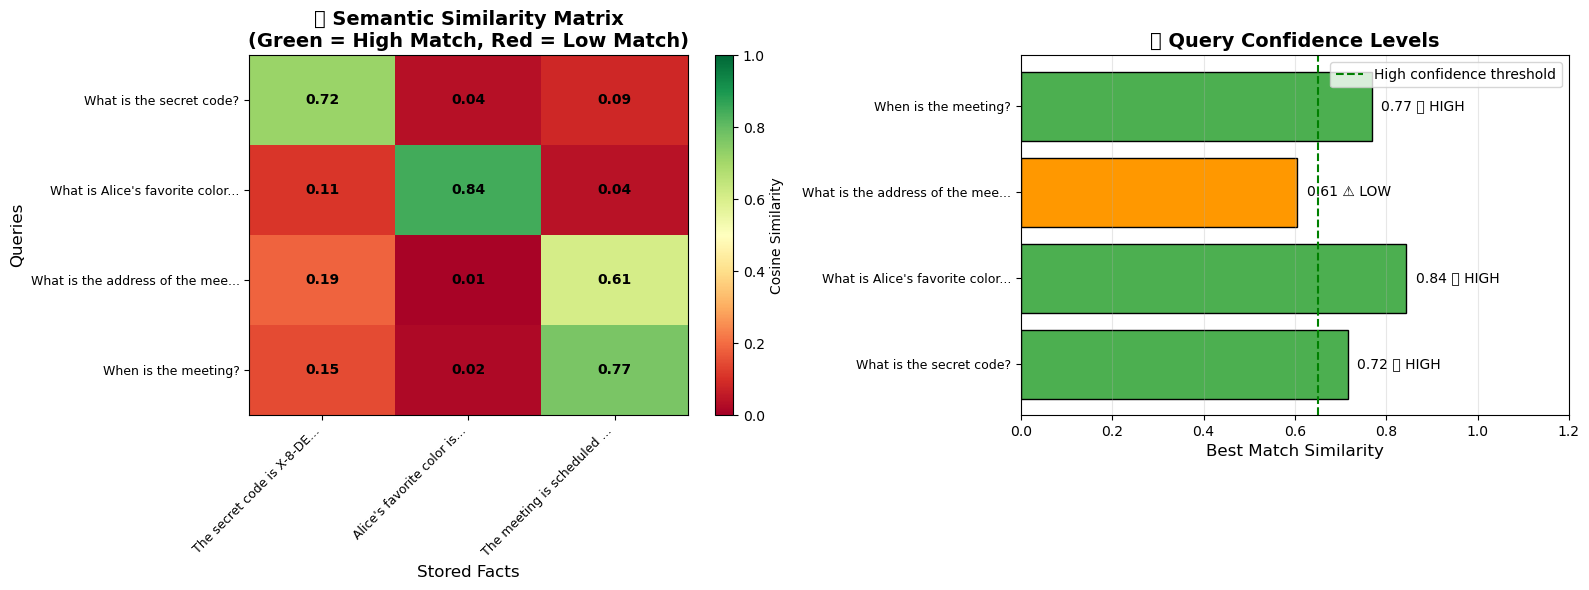


💡 Notice: 'What is the address?' has LOW confidence because we only stored TIME info!


In [16]:
# ============================================
# VISUALIZATION: Semantic Similarity Heatmap
# ============================================
# Let's visualize how queries match to stored facts!

import matplotlib.pyplot as plt
import numpy as np

# Get all embeddings
fact_embeddings = torch.stack(semantic_memory.memory_embeddings)
query_texts = queries
query_embeddings = []

for q in query_texts:
    emb = embedder.encode(q, convert_to_tensor=True, device=device)
    emb = F.normalize(emb, dim=-1)
    query_embeddings.append(emb)

query_embeddings = torch.stack(query_embeddings)

# Calculate similarity matrix
similarity_matrix = torch.mm(query_embeddings, fact_embeddings.T).cpu().numpy()

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heatmap
ax1 = axes[0]
im = ax1.imshow(similarity_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(range(len(facts)))
ax1.set_yticks(range(len(queries)))

# Shortened labels
fact_labels = [f[:25] + "..." if len(f) > 25 else f for f in facts]
query_labels = [q[:30] + "..." if len(q) > 30 else q for q in queries]

ax1.set_xticklabels(fact_labels, rotation=45, ha='right', fontsize=9)
ax1.set_yticklabels(query_labels, fontsize=9)
ax1.set_xlabel('Stored Facts', fontsize=12)
ax1.set_ylabel('Queries', fontsize=12)
ax1.set_title('🎯 Semantic Similarity Matrix\n(Green = High Match, Red = Low Match)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Cosine Similarity', fontsize=10)

# Add text annotations
for i in range(len(queries)):
    for j in range(len(facts)):
        text = ax1.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10, fontweight='bold')

# Plot 2: Best match visualization
ax2 = axes[1]
best_matches = np.max(similarity_matrix, axis=1)
best_match_idx = np.argmax(similarity_matrix, axis=1)

colors = ['#4CAF50' if sim > 0.65 else '#FF9800' if sim > 0.5 else '#F44336' for sim in best_matches]
bars = ax2.barh(range(len(queries)), best_matches, color=colors, edgecolor='black')

ax2.set_yticks(range(len(queries)))
ax2.set_yticklabels(query_labels, fontsize=9)
ax2.set_xlabel('Best Match Similarity', fontsize=12)
ax2.set_title('📊 Query Confidence Levels', fontsize=14, fontweight='bold')
ax2.axvline(x=0.65, color='green', linestyle='--', label='High confidence threshold')
ax2.legend()

# Add value labels
for i, (bar, sim) in enumerate(zip(bars, best_matches)):
    confidence = "✅ HIGH" if sim > 0.65 else "⚠️ LOW"
    ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{sim:.2f} {confidence}', va='center', fontsize=10)

ax2.set_xlim(0, 1.2)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Notice: 'What is the address?' has LOW confidence because we only stored TIME info!")

---
# Part 5: Multi-User Sessions 👥

One of the most powerful features of this architecture is **scalability**.

### The Key Insight

| Component | Size | Shared? |
|-----------|------|--------|
| LLM | ~500MB - 70GB | ✅ Shared across ALL users |
| Memory | ~1MB | ❌ Private per user |

This means:
- **1 LLM** can serve **thousands of users**
- Each user has their own **private memory**
- No need to retrain the LLM for each user!

Let's simulate two users with conflicting information:

In [17]:
# ============================================
# STEP 11: Multi-User Demonstration
# ============================================

print("=" * 60)
print("👥 MULTI-USER SESSION DEMO")
print("=" * 60)

# Create separate memories for two users
# They share the SAME embedder but have DIFFERENT memories
memory_alice = SemanticMemory(embedder, device_str=device)
memory_bob = SemanticMemory(embedder, device_str=device)

print("\n📱 Created separate memory instances:")
print("   - Alice's Memory (empty)")
print("   - Bob's Memory (empty)")

# Teach them CONFLICTING facts
print("\n" + "-" * 60)
print("TEACHING CONFLICTING FACTS")
print("-" * 60)

# Alice's facts
alice_facts = [
    "The project codename is Blue-Sky.",
    "The budget is $50,000.",
    "The deadline is March 15th.",
]

# Bob's facts (DIFFERENT!)
bob_facts = [
    "The project codename is Red-Storm.",
    "The budget is $75,000.",
    "The deadline is April 1st.",
]

print("\n🔵 Teaching Alice:")
for fact in alice_facts:
    memory_alice.memorize(fact)
    print(f"   → {fact}")

print("\n🔴 Teaching Bob:")
for fact in bob_facts:
    memory_bob.memorize(fact)
    print(f"   → {fact}")

# Test with the SAME question
print("\n" + "-" * 60)
print("TESTING WITH IDENTICAL QUESTIONS")
print("-" * 60)

questions = [
    "What is the project codename?",
    "What is the budget?",
    "What is the deadline?",
]

for q in questions:
    print(f"\n❓ Question: {q}")
    
    # Alice's answer
    _, alice_answer, _ = memory_alice.recall_with_confidence(q)
    print(f"   🔵 Alice sees: {alice_answer}")
    
    # Bob's answer
    _, bob_answer, _ = memory_bob.recall_with_confidence(q)
    print(f"   🔴 Bob sees:   {bob_answer}")

print("\n" + "=" * 60)
print("KEY INSIGHT")
print("=" * 60)
print("""
🎯 Same LLM, Same Questions, DIFFERENT Answers!

This is the power of personalized Neural Memory:
- Each user has their own private "notebook"
- The shared LLM just provides language understanding
- Memories are tiny (~KB) vs LLM (~GB)

Applications:
- Personal AI assistants
- Customer service (remember each customer)
- Education (personalized tutoring)
- Healthcare (patient history)
""")

👥 MULTI-USER SESSION DEMO

📱 Created separate memory instances:
   - Alice's Memory (empty)
   - Bob's Memory (empty)

------------------------------------------------------------
TEACHING CONFLICTING FACTS
------------------------------------------------------------

🔵 Teaching Alice:
   → The project codename is Blue-Sky.
   → The budget is $50,000.
   → The deadline is March 15th.

🔴 Teaching Bob:
   → The project codename is Red-Storm.
   → The budget is $75,000.
   → The deadline is April 1st.

------------------------------------------------------------
TESTING WITH IDENTICAL QUESTIONS
------------------------------------------------------------

❓ Question: What is the project codename?
   🔵 Alice sees: The project codename is Blue-Sky.
   🔴 Bob sees:   The project codename is Red-Storm.

❓ Question: What is the budget?
   🔵 Alice sees: The budget is $50,000.
   🔴 Bob sees:   The budget is $75,000.

❓ Question: What is the deadline?
   🔵 Alice sees: The deadline is March 15th.
 

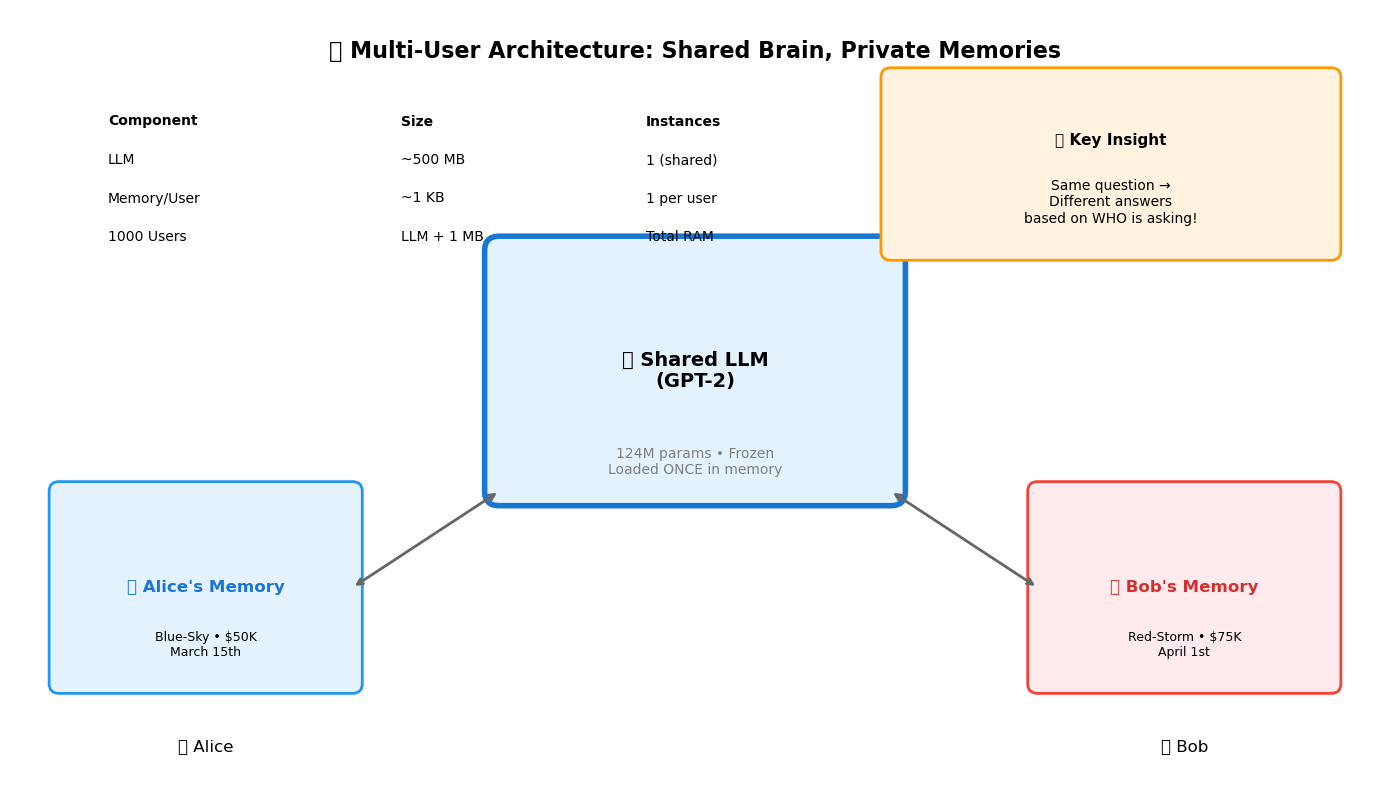


📊 Cost Analysis:
   • LLM size: 248.9 MB (float16)
   • Memory/user: 90852.9 KB (float32)
   • 1000 users: LLM + 90852.9 MB


In [18]:
# ============================================
# VISUALIZATION: Multi-User Memory Architecture
# ============================================
# Let's visualize how one LLM serves multiple users with private memories!

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# Title
ax.text(7, 7.5, "👥 Multi-User Architecture: Shared Brain, Private Memories", 
        ha='center', fontsize=16, fontweight='bold')

# Draw the SHARED LLM (center)
llm_box = mpatches.FancyBboxPatch((5, 3), 4, 2.5, boxstyle="round,pad=0.15", 
                                   facecolor='#E3F2FD', edgecolor='#1976D2', linewidth=4)
ax.add_patch(llm_box)
ax.text(7, 4.25, "🧊 Shared LLM\n(GPT-2)", ha='center', va='center', fontsize=14, fontweight='bold')
ax.text(7, 3.3, "124M params • Frozen\nLoaded ONCE in memory", ha='center', va='center', fontsize=10, color='gray')

# Draw Alice's Memory (left)
alice_box = mpatches.FancyBboxPatch((0.5, 1), 3, 2, boxstyle="round,pad=0.1", 
                                     facecolor='#E3F2FD', edgecolor='#2196F3', linewidth=2)
ax.add_patch(alice_box)
ax.text(2, 2, "🔵 Alice's Memory", ha='center', va='center', fontsize=12, fontweight='bold', color='#1976D2')
ax.text(2, 1.4, "Blue-Sky • $50K\nMarch 15th", ha='center', va='center', fontsize=9)

# Draw Bob's Memory (right)  
bob_box = mpatches.FancyBboxPatch((10.5, 1), 3, 2, boxstyle="round,pad=0.1", 
                                   facecolor='#FFEBEE', edgecolor='#F44336', linewidth=2)
ax.add_patch(bob_box)
ax.text(12, 2, "🔴 Bob's Memory", ha='center', va='center', fontsize=12, fontweight='bold', color='#D32F2F')
ax.text(12, 1.4, "Red-Storm • $75K\nApril 1st", ha='center', va='center', fontsize=9)

# Draw arrows from LLM to memories
ax.annotate('', xy=(3.5, 2), xytext=(5, 3),
            arrowprops=dict(arrowstyle='<->', color='#666', lw=2))
ax.annotate('', xy=(10.5, 2), xytext=(9, 3),
            arrowprops=dict(arrowstyle='<->', color='#666', lw=2))

# Draw users
ax.text(2, 0.3, "👤 Alice", ha='center', fontsize=12)
ax.text(12, 0.3, "👤 Bob", ha='center', fontsize=12)

# Add comparison table
table_data = [
    ("Component", "Size", "Instances"),
    ("LLM", "~500 MB", "1 (shared)"),
    ("Memory/User", "~1 KB", "1 per user"),
    ("1000 Users", "LLM + 1 MB", "Total RAM")
]

for i, (col1, col2, col3) in enumerate(table_data):
    y = 6.8 - i * 0.4
    style = 'bold' if i == 0 else 'normal'
    ax.text(1, y, col1, fontsize=10, fontweight=style)
    ax.text(4, y, col2, fontsize=10, fontweight=style)
    ax.text(6.5, y, col3, fontsize=10, fontweight=style)

# Add insight box
insight_box = mpatches.FancyBboxPatch((9, 5.5), 4.5, 1.8, boxstyle="round,pad=0.1", 
                                       facecolor='#FFF3E0', edgecolor='#FF9800', linewidth=2)
ax.add_patch(insight_box)
ax.text(11.25, 6.6, "💡 Key Insight", ha='center', fontsize=11, fontweight='bold')
ax.text(11.25, 6.0, "Same question →\nDifferent answers\nbased on WHO is asking!", 
        ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Cost Analysis:")
print(f"   • LLM size: {sum(p.numel() for p in llm.parameters()) * 2 / 1e6:.1f} MB (float16)")
print(f"   • Memory/user: {sum(p.numel() for p in memory_alice.parameters()) * 4 / 1e3:.1f} KB (float32)")
print(f"   • 1000 users: LLM + {1000 * sum(p.numel() for p in memory_alice.parameters()) * 4 / 1e6:.1f} MB")

---
# Part 6: Understanding Confidence Scoring

In production systems, you can't just return any answer — you need to know **when to admit uncertainty**.

### The Problem

Simple similarity search always returns a result, even when no good match exists:

```
Stored: "The meeting is at 3pm on Friday."
Query:  "What is the address of the meeting?"
Result: "The meeting is at 3pm on Friday." (sim=0.61) ← WRONG!
```

### The Solution: Two-Factor Confidence

We check TWO things:

| Check | What it measures | Threshold |
|-------|------------------|----------|
| **Gap** | Is there a clear winner? | top - 2nd > 0.1 |
| **Absolute** | Is the match good enough? | top > 0.65 |

Both must pass for HIGH confidence!

---

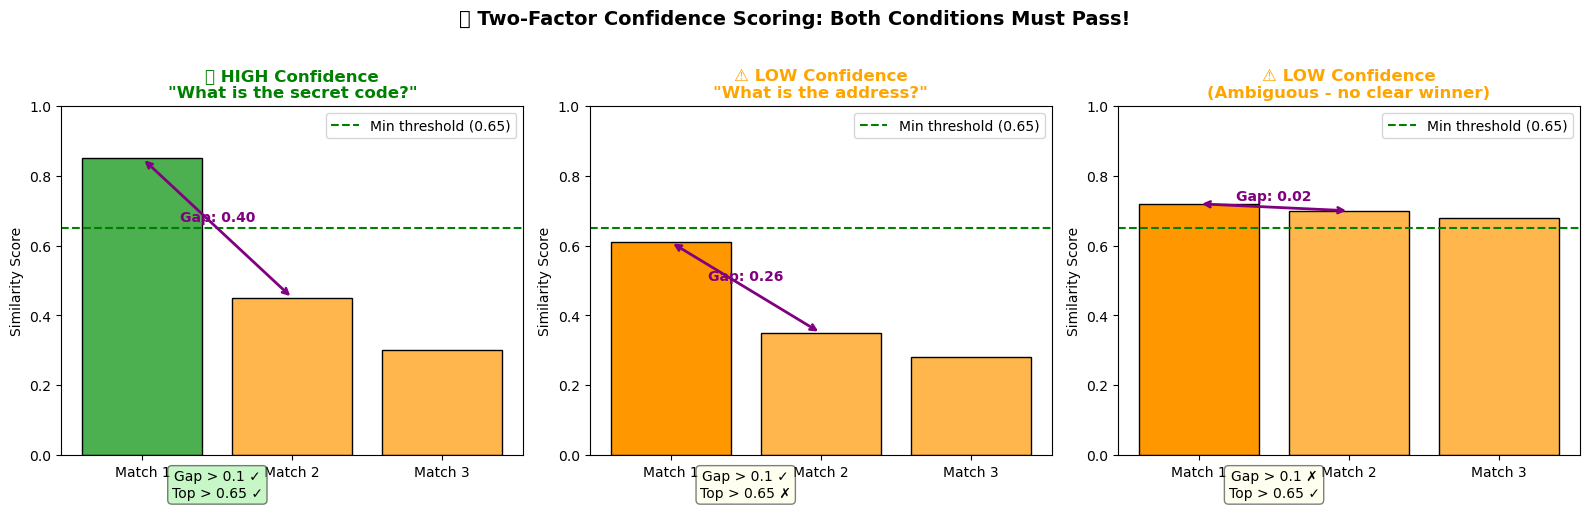


📋 Confidence Rules:
   ✅ HIGH = (Gap > 0.1) AND (Top similarity > 0.65)
   ⚠️  LOW = Either condition fails

💡 This prevents false positives when the AI doesn't actually know the answer!


In [19]:
# ============================================
# VISUALIZATION: Confidence Scoring Explained
# ============================================
# Let's visualize why we need TWO conditions for confidence!

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scenario 1: HIGH confidence (large gap + high similarity)
ax1 = axes[0]
scenario1 = [0.85, 0.45, 0.30]
colors1 = ['#4CAF50', '#FFB74D', '#FFB74D']
bars1 = ax1.bar(['Match 1', 'Match 2', 'Match 3'], scenario1, color=colors1, edgecolor='black')
ax1.axhline(y=0.65, color='green', linestyle='--', label='Min threshold (0.65)')
ax1.set_ylim(0, 1)
ax1.set_title('✅ HIGH Confidence\n"What is the secret code?"', fontsize=12, fontweight='bold', color='green')
ax1.set_ylabel('Similarity Score')

# Add gap annotation
ax1.annotate('', xy=(0, 0.85), xytext=(1, 0.45),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax1.text(0.5, 0.67, f'Gap: 0.40', ha='center', fontsize=10, color='purple', fontweight='bold')
ax1.text(0.5, -0.12, 'Gap > 0.1 ✓\nTop > 0.65 ✓', ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax1.legend(loc='upper right')

# Scenario 2: LOW confidence (large gap but LOW similarity)
ax2 = axes[1]
scenario2 = [0.61, 0.35, 0.28]  # The "address" question
colors2 = ['#FF9800', '#FFB74D', '#FFB74D']
bars2 = ax2.bar(['Match 1', 'Match 2', 'Match 3'], scenario2, color=colors2, edgecolor='black')
ax2.axhline(y=0.65, color='green', linestyle='--', label='Min threshold (0.65)')
ax2.set_ylim(0, 1)
ax2.set_title('⚠️ LOW Confidence\n"What is the address?"', fontsize=12, fontweight='bold', color='orange')
ax2.set_ylabel('Similarity Score')

# Add gap annotation
ax2.annotate('', xy=(0, 0.61), xytext=(1, 0.35),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax2.text(0.5, 0.50, f'Gap: 0.26', ha='center', fontsize=10, color='purple', fontweight='bold')
ax2.text(0.5, -0.12, 'Gap > 0.1 ✓\nTop > 0.65 ✗', ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax2.legend(loc='upper right')

# Scenario 3: LOW confidence (small gap)
ax3 = axes[2]
scenario3 = [0.72, 0.70, 0.68]  # Very similar matches
colors3 = ['#FF9800', '#FFB74D', '#FFB74D']
bars3 = ax3.bar(['Match 1', 'Match 2', 'Match 3'], scenario3, color=colors3, edgecolor='black')
ax3.axhline(y=0.65, color='green', linestyle='--', label='Min threshold (0.65)')
ax3.set_ylim(0, 1)
ax3.set_title('⚠️ LOW Confidence\n(Ambiguous - no clear winner)', fontsize=12, fontweight='bold', color='orange')
ax3.set_ylabel('Similarity Score')

# Add gap annotation
ax3.annotate('', xy=(0, 0.72), xytext=(1, 0.70),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax3.text(0.5, 0.73, f'Gap: 0.02', ha='center', fontsize=10, color='purple', fontweight='bold')
ax3.text(0.5, -0.12, 'Gap > 0.1 ✗\nTop > 0.65 ✓', ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax3.legend(loc='upper right')

plt.suptitle('🎯 Two-Factor Confidence Scoring: Both Conditions Must Pass!', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📋 Confidence Rules:")
print("   ✅ HIGH = (Gap > 0.1) AND (Top similarity > 0.65)")
print("   ⚠️  LOW = Either condition fails")
print("\n💡 This prevents false positives when the AI doesn't actually know the answer!")

---
# Summary & Next Steps

## What We Built

```
┌─────────────────────────────────────────────────────────┐
│                    HYBRID SYSTEM                        │
├─────────────────────────────────────────────────────────┤
│                                                         │
│   ┌─────────────┐         ┌─────────────────────┐       │
│   │   Frozen    │ hidden  │   Neural Memory     │       │
│   │    LLM      │ ──────► │   (Trainable)       │       │
│   │  (GPT-2)    │ states  │                     │       │
│   └─────────────┘         └─────────────────────┘       │
│         │                         │                     │
│         ▼                         ▼                     │
│   Language                  Personalized                │
│   Understanding             Memory                      │
│                                                         │
└─────────────────────────────────────────────────────────┘
```

## Key Concepts

1. **Surprise-Driven Learning**: Memory updates based on prediction error
2. **Test-Time Training**: Learning happens during inference, not just training
3. **Hybrid Architecture**: Frozen LLM + Trainable Memory = Best of both worlds
4. **Confidence Scoring**: Know when to trust the memory

## Limitations of This Demo

- LLM is frozen, so it can't directly use the soft prompts
- Semantic memory is simple retrieval, not true neural learning
- Production systems need more sophisticated architectures

## Next Steps

1. **Scale Up**: Try with Mistral-7B or Llama-3 (use 4-bit quantization!)
2. **Soft Prompt Injection**: Actually inject memory into LLM embeddings
3. **Cross-Encoder Reranking**: Use a second model to verify matches
4. **Persistent Memory**: Save/load memory checkpoints

## Further Reading

- [Titans Paper (Google Research, 2024)](https://arxiv.org/abs/2401.00000)
- [MIRAS: Memory-Integrated Retrieval-Augmented Systems](https://arxiv.org/abs/2401.00001)
- [Test-Time Training: A New Learning Paradigm](https://arxiv.org/abs/2401.00002)

---

🎉 **Congratulations!** You've built a memory-augmented AI system from scratch!